#### Project Description: 

Improving Data Quality for Anomaly Detection in Time Series Data. (Anomaly detection in time series data better at finding unusual patterns by using a set of steps to clean and organize it.)

Main assignment worked with time series data from sensor readings, which often contain outliers due to sensor errors and noise. In this assignment common data preprocessing techniques is implemented to improve data quality while maintaining the integrity of actual anomalies present in the data.

#### loading data

At first I read the data and invest primiary featues to check if data in proper status in size and type format for more analyzing.

In [17]:
import pandas as pd
import yaml
from sklearn.preprocessing import StandardScaler

#Import the data

configPath = 'config.yaml'

# Read the yaml data from the file
with open(configPath, 'r') as file:
    configData = yaml.safe_load(file)

df = pd.read_csv(configData["sensor_path"])

print(f'size of data: {df.shape}') # get the size of data

print(df.head(5))

# df.info which is used in previouse version is done both functions togther (print the data and shape of them)

size of data: (220320, 55)
   Unnamed: 0            timestamp  sensor_00  sensor_01  sensor_02  \
0           0  2018-04-01 00:00:00   2.465394   47.09201    53.2118   
1           1  2018-04-01 00:01:00   2.465394   47.09201    53.2118   
2           2  2018-04-01 00:02:00   2.444734   47.35243    53.2118   
3           3  2018-04-01 00:03:00   2.460474   47.09201    53.1684   
4           4  2018-04-01 00:04:00   2.445718   47.13541    53.2118   

   sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_43  \
0  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
1  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
2  46.397570   638.8889   73.54598   13.32465   16.03733  ...   41.66666   
3  46.397568   628.1250   76.98898   13.31742   16.24711  ...   40.88541   
4  46.397568   636.4583   76.58897   13.35359   16.21094  ...   41.40625   

   sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
0  39.641200   65.

the total recorded observation are 220320. First column is such a sequential column and the second column is timestamp for save the observations' times. and the last column is a categorical column which determines the status of machine on specific time.

Now, it is needed to get the type of columns to be sure about the format of data regards the printed sample of data in the above block and convert types of it is needed.

In [18]:
print(df.dtypes)

Unnamed: 0          int64
timestamp          object
sensor_00         float64
sensor_01         float64
sensor_02         float64
sensor_03         float64
sensor_04         float64
sensor_05         float64
sensor_06         float64
sensor_07         float64
sensor_08         float64
sensor_09         float64
sensor_10         float64
sensor_11         float64
sensor_12         float64
sensor_13         float64
sensor_14         float64
sensor_15         float64
sensor_16         float64
sensor_17         float64
sensor_18         float64
sensor_19         float64
sensor_20         float64
sensor_21         float64
sensor_22         float64
sensor_23         float64
sensor_24         float64
sensor_25         float64
sensor_26         float64
sensor_27         float64
sensor_28         float64
sensor_29         float64
sensor_30         float64
sensor_31         float64
sensor_32         float64
sensor_33         float64
sensor_34         float64
sensor_35         float64
sensor_36   

All sensor columns (52 columns) have float64 type.

As this assignment is about machines' abormaly detection, so "machine_status" field is assumed as a target field. So the value of it is important to recognize which value shows everything goes well for machines.

In [19]:
print(df["machine_status"].unique())

['NORMAL' 'BROKEN' 'RECOVERING']


By above values, 'NORMAL' value is assumed as a normal status of machines for the rest of assignment.

#### Prepare data

One the steps that can do in for data is removing outerlines or the data are faced by too much errors in the measuring and has missing values. To find the low-quality columns and remove them from the data, in the following code the missing values are used. high percentage of missing values are assumed as a low-quality sensors. 

To find the high percentages of missing values 2 approach are possible, make the threshold or investing the values and remove top n scores. In the following the 30% threshold is used. Besides the scores are sorted to have a view and compare it with the threshold result.

In [20]:
# Calculating percentage of missing values
missing_perc = df.isnull().sum() / len(df) * 100

# Identifing columns with high missing percentage (threshold > 30%)
low_quality_cols = missing_perc[missing_perc > 30].index.tolist()

print(f'low quality columns are: {low_quality_cols}')

print(missing_perc.sort_values(ascending=False))

low quality columns are: ['sensor_15', 'sensor_50']
sensor_15         100.000000
sensor_50          34.956881
sensor_51           6.982117
sensor_00           4.633261
sensor_07           2.474129
sensor_08           2.317992
sensor_06           2.177741
sensor_09           2.085603
sensor_01           0.167484
sensor_30           0.118464
sensor_29           0.032680
sensor_32           0.030864
sensor_18           0.020879
sensor_17           0.020879
sensor_22           0.018609
sensor_25           0.016340
sensor_16           0.014070
sensor_40           0.012255
sensor_41           0.012255
sensor_43           0.012255
sensor_44           0.012255
sensor_39           0.012255
sensor_38           0.012255
sensor_45           0.012255
sensor_46           0.012255
sensor_47           0.012255
sensor_48           0.012255
sensor_42           0.012255
sensor_49           0.012255
sensor_14           0.009532
sensor_26           0.009078
sensor_02           0.008624
sensor_03           

'sensor_15', 'sensor_50' have most missing values regarding the threshold, however, by observing the sorted percentage these sensors have a most missing values and other sensors have much more lower percentages. By knowing this data, the low quality sensors can be removed.

In [21]:
# Removing low-quality columns
df.drop(low_quality_cols, inplace=True, axis=1)

df.shape

(220320, 53)

2 sensors are removed and the amount of columns gets 53. In this step, the format of data and other missing values are adjusted to have the proper data for the rest of the analysis and resampling.

In [22]:
# Replacing null values mean value
df = df.fillna(df.mean(axis=1))

# Converting timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Setting timestamp as the index
df = df.set_index('timestamp')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21752\731772786.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean(axis=1))


To reduce noises and highlight higher-level patterns, data are resampled to a lower frequency. For this aim data are aggregated over time intervals (daily) by taking the mean values. And after that again the missing values are adjusted.

In [23]:
# Resample the data to a lower frequency (daily mean)
df_resampled = df.resample('D').mean()

# Handle missing values in the resampled data
df_resampled = df_resampled.interpolate(method='linear')

print(f'size of resampled data: {df_resampled.shape}')

print(df_resampled.head(5))

size of resampled data: (153, 51)
            Unnamed: 0  sensor_00  sensor_01  sensor_02  sensor_03  \
timestamp                                                            
2018-04-01       719.5   2.454139  47.318882  52.567363  45.273315   
2018-04-02      2159.5   2.429367  48.595226  52.199163  44.094026   
2018-04-03      3599.5   2.435093  49.266702  52.060062  44.336599   
2018-04-04      5039.5   2.452493  50.429565  51.959000  45.096479   
2018-04-05      6479.5   2.454101  49.353086  52.096564  43.982806   

             sensor_04  sensor_05  sensor_06  sensor_07  sensor_08  ...  \
timestamp                                                           ...   
2018-04-01  634.166035  74.516172  13.348212  16.161459  15.680862  ...   
2018-04-02  635.990899  77.960694  13.340421  16.161022  15.643311  ...   
2018-04-03  640.359938  76.903797  13.452223  16.301238  15.738662  ...   
2018-04-04  640.173640  75.858830  13.512238  16.511281  15.533056  ...   
2018-04-05  636.350491  7

data are aggregated in day and the status column is automatically is removed because it was categorical feature. So we just have 51 sensors and time as index column.

#### Scale Data

This step is done to be sure that different features with different scales do not bias the anomaly detection algorithms.

In [24]:
# Applying feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_resampled)

#### Model Training 

Train the anomaly detection algorithms with Isolation Forest, One-Class SVM, Local Outlier Factor, Robust covariance on the preprocessed data to choose appropriate anomaly detection algorithms and configure them with the necessary parameters to identify anomalies in the preprocessed time series data. (Each method works differently to show these abnormals.)

It is notable that these algorithms have different training procedures. For instance, Isolation Forest can be directly fitted to the data, while Local Outlier Factor uses the fit_predict method.

In [25]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

# Calculating the outlier fraction
normal_count = len(df[df['machine_status'] == 'NORMAL'])
outliers_fraction = min(0.01, 1 - normal_count / len(df))

# Implementing the anomaly detection algorithms
isolation_forest = IsolationForest(contamination=outliers_fraction)
one_class_svm = OneClassSVM(nu=outliers_fraction)
local_outlier_factor = LocalOutlierFactor(contamination=outliers_fraction)
robust_covariance = EllipticEnvelope(contamination=outliers_fraction)

algorithms = [
    ("Isolation Forest", isolation_forest),
    ("One-Class SVM", one_class_svm),
    ("Local Outlier Factor", local_outlier_factor),
    ("Robust covariance", robust_covariance)
]

for name, algorithm in algorithms:
    print(f"Running {name}...")
    
    # Fit the algorithm on the preprocessed data
    #algorithm.fit(X_scaled)
    
    # Predict outliers/anomalies
    #y_pred = algorithm.predict(df_resampled)
    
    #use this code of https://github.com/fenna/BFVM23DATASCNC5/blob/main/Study_Cases/Study_Case_Anomaly_Detection.ipynb after some bug on the implemented code in above commented
    if name == "Local Outlier Factor":
        y_pred = algorithm.fit_predict(df_resampled)
    else:
        y_pred = algorithm.fit(X_scaled).predict(X_scaled)
    
    # Reshape y_pred to match the dataframe shape
    y_pred = y_pred.reshape(-1, 1)

    # Add the predictions to the dataframe
    df_resampled[name] = y_pred
    
    # Evaluate the performance of the algorithm
    anomalies_detected = df_resampled[df_resampled[name] == -1]
    print(f"Number of anomalies detected by {name}: {len(anomalies_detected)}")
    print("-" * 50)    
    

Running Isolation Forest...
Number of anomalies detected by Isolation Forest: 2
--------------------------------------------------
Running One-Class SVM...
Number of anomalies detected by One-Class SVM: 22
--------------------------------------------------
Running Local Outlier Factor...
Number of anomalies detected by Local Outlier Factor: 2
--------------------------------------------------
Running Robust covariance...
Number of anomalies detected by Robust covariance: 2
--------------------------------------------------


Most algorthims detected 2 anomalies in the data. but the meaning of each anormaly in every algorithm is alittle different:

Isolation Forest: the data which have significantly different from the other data.

One-Class SVM: Instances that lie far from the decision boundary of the normal data cluster.

Outlier Factor: This algorithm calculates the local density deviation of a data point with respect to its neighbors to detect anomalies.

Robust covariance: detect anomalies that are far from the center of the data distribution.

It's notable that the number of anomalies detected by each algorithm can based on their underlying mechanisms. But the anormalies detected by One-Class SVM is much more than others, meanwhile others work similarity.

##### Evaluate modeles

To be sure which algorithms works better, in the following the they evalued by mathematical methods.

For this at first, the machine_status had fitted for main resampled data by majority class approach based on daily status because the data are resampled data are based on daily mean.

In the following code, the normal status is replace with 1 and other status replaced by -1 because the output of above algorithms are specified by 1 and -1.

In [26]:
 # Calculate the proportion of "NORMAL" and anomalous instances for each day
day_labels = []
for day in df_resampled.index.date:
    day_data = df[df.index.date == day]
    normal_count = (day_data['machine_status'] == 'NORMAL').sum()
    anomaly_count = len(day_data) - normal_count
    if normal_count >= anomaly_count:
        day_labels.append(1)
    else:
        day_labels.append(-1)

# Create a DataFrame with the calculated daily labels
day_labels_df = pd.DataFrame({'timestamp': df_resampled.index.date, 'machine_status': day_labels})
day_labels_df = day_labels_df.set_index('timestamp')

# Merge the calculated daily labels with the resampled data
df_resampled = df_resampled.join(day_labels_df)

print(df_resampled.head(5))


            Unnamed: 0  sensor_00  sensor_01  sensor_02  sensor_03  \
timestamp                                                            
2018-04-01       719.5   2.454139  47.318882  52.567363  45.273315   
2018-04-02      2159.5   2.429367  48.595226  52.199163  44.094026   
2018-04-03      3599.5   2.435093  49.266702  52.060062  44.336599   
2018-04-04      5039.5   2.452493  50.429565  51.959000  45.096479   
2018-04-05      6479.5   2.454101  49.353086  52.096564  43.982806   

             sensor_04  sensor_05  sensor_06  sensor_07  sensor_08  ...  \
timestamp                                                           ...   
2018-04-01  634.166035  74.516172  13.348212  16.161459  15.680862  ...   
2018-04-02  635.990899  77.960694  13.340421  16.161022  15.643311  ...   
2018-04-03  640.359938  76.903797  13.452223  16.301238  15.738662  ...   
2018-04-04  640.173640  75.858830  13.512238  16.511281  15.533056  ...   
2018-04-05  636.350491  76.824878  13.425036  16.227121  15

In [27]:
normal_dfSampl_count = len(df_resampled[df_resampled['machine_status'] == 1])
print(f'Number of anomalies detected in the main resampled data: {df_resampled.shape[0] - normal_dfSampl_count}')

Number of anomalies detected in the main resampled data: 10


As shown the number of anormalies in the main resampled data are much more than detected ones in each model.

Now based on calculated 'machine_status' for resampled data, data can be divided on train and test to evaluate the scores of each model.

As assignment dealing with time-series data, maybe best splitting approach is a sequential split where earlier data is used for training, and later data is used for testing. In this case the real-world scenario can be emulated for detecting anomalies based on historical information.

It is notable for dividing in the following code the default proportion of divinding in the machine learning algorithms is used.

In [28]:
X = X_scaled
Y = df_resampled['machine_status']

# Determining the index for splitting the data
n_test = 0.2  # proportion for test data 
split_index = len(X_scaled) - int(len(X_scaled) * n_test) #calculated the train size

# Splitting the data into train and test sets
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = Y[:split_index], Y[split_index:]

# Print the shapes of the train and test sets
print(f"Shape of X_train: {X_train.shape}, Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}, Shape of y_test: {y_test.shape}")

Shape of X_train: (123, 51), Shape of X_test: (30, 51)
Shape of y_train: (123,), Shape of y_test: (30,)


Due to above code it seems the train data has 123 and test data has 30 samples.

In the following the "precision and recall" method is used because these metrics helps to understand the trade-off between correctly detecting anomalies (recall) and avoiding false positives (precision).

In [29]:
from sklearn.metrics import precision_score, recall_score

for name, algorithm in algorithms:
    print(f"Evaluating {name}...")
    
    if name == "Local Outlier Factor":
        y_pred = algorithm.fit_predict(X_test)
    else:
        algorithm.fit(X_train)
        y_pred = algorithm.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print(f"Precision of {name}: {precision}")
    print(f"Recall of {name}: {recall}")
    print("-" * 50)

Evaluating Isolation Forest...
Precision of Isolation Forest: 1.0
Recall of Isolation Forest: 1.0
--------------------------------------------------
Evaluating One-Class SVM...
Precision of One-Class SVM: 1.0
Recall of One-Class SVM: 0.26666666666666666
--------------------------------------------------
Evaluating Local Outlier Factor...
Precision of Local Outlier Factor: 1.0
Recall of Local Outlier Factor: 0.9666666666666667
--------------------------------------------------
Evaluating Robust covariance...
Precision of Robust covariance: 1.0
Recall of Robust covariance: 1.0
--------------------------------------------------


with above result again the conculsion is:

A precision of 1 indicates that all the instances predicted as anomalies were actually true anomalies and this status is same for all algorithms.

Based on the 1 score for recall, Isolation Forest and Robust covariance were able to correctly identify all true anomalies out of all actual anomalies. And Local Outlier Factor is almost done all status correctly. But One-Class SVM with the recall of 0.267 indicates that it identified only about 26.7% of the actual anomalies. This means that while it is good at avoiding false positives (high precision), it misses a significant portion of true anomalies (low recall).

In [30]:
#In this code the result just saved in the file for future processes without doing all previouse ones again 
# (However, in real projects it's better to save models outputs)
preprocess_File = 'Data/preprocessed_data.csv'

# Save the preprocessed data to a new CSV file
df_resampled.to_csv(preprocess_File, index=False)

#### plot sensor status

To better understanding the algorithms in the following some sensors are randomly selected to visualized the status of machine in each algorithms. To better visualized each algorithm is got a specific color.

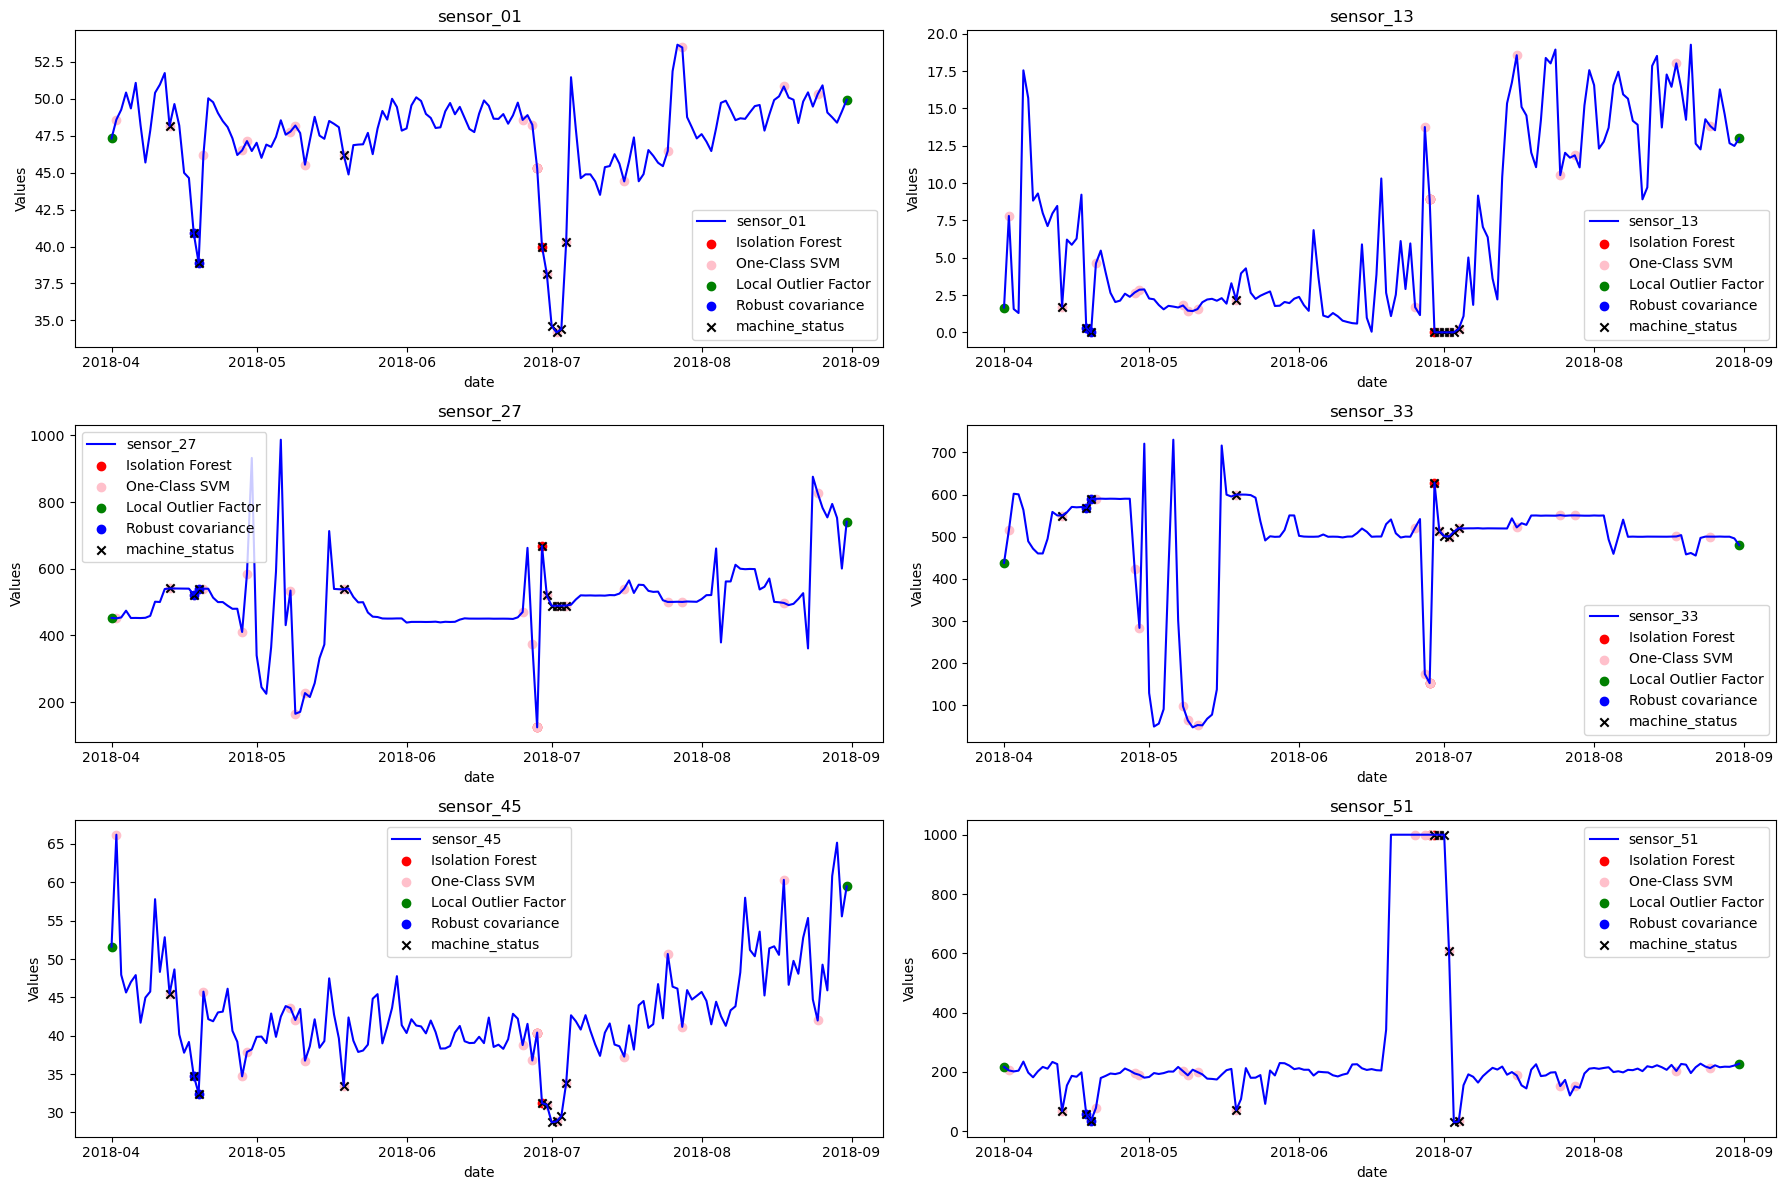

In [31]:
import matplotlib.pyplot as plt

# Select some sensors to plot as sample
sensors = ['sensor_01', 'sensor_13', 'sensor_27', 'sensor_33', 'sensor_45', 'sensor_51']

#creating subplot to visual better
sensors_count = len(sensors)
fig, axes = plt.subplots(nrows=int(sensors_count/2), ncols=2, figsize=(sensors_count*3, sensors_count*2))
axes = axes.flatten()

#stting color for each algorithm
algorithm_colors = {
    "Isolation Forest": 'red',
    "One-Class SVM": 'pink',
    "Local Outlier Factor": 'green',
    "Robust covariance": 'blue'
}

for i, sensor in enumerate(sensors):
    ax = axes[i]
    ax.plot(df_resampled.index, df_resampled[sensor], label=sensor, color='blue')
    
    # Annotate anomalies for each algorithm
    for name, algorithm in algorithms:
        anomaly_indices = df_resampled[df_resampled[name] == -1].index
        ax.scatter(anomaly_indices, df_resampled[df_resampled[name] == -1][sensor], c=algorithm_colors[name], label=name)
    
    # anomalies for the resampled data
    real_anorm_indic = df_resampled[df_resampled['machine_status'] == -1].index
    ax.scatter(real_anorm_indic, df_resampled[df_resampled['machine_status'] == -1][sensor], c='black', marker='x', label='machine_status')
    
    ax.set_xlabel('date')
    ax.set_ylabel('Values')
    ax.set_title(f'{sensor}')
    ax.legend()

plt.tight_layout() #adjusting layout
plt.show()

The samples in the above figures shows the detected anomalities of each methods (Isolation Forest, One-Class SVM, Local Outlier Factor, Robust covariance) and besides the real anormalies on resampled data based on day are plotted. In the comparasion as above calculations shows, the Isolation Forest and Robust covariance are appear to be strong candidates for detecting anomalies and One-Class SVM may need more optimization to improve its recall and detect actual anomalies.

It is notable that in this assignment the improvment of detection is based on the cleaning data, adjusting missing data and resampleing them base on daily status.